# Block Model with a 1D background - Comparison

### For the model, see the notebook BlockModel.ipynb

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Load data

In [3]:
def extract_lines(name):
    inp = xr.load_dataset(name, engine='h5netcdf')
    print_attributes(inp)
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out


def print_attributes(inp):
    for key in ['runtime', 'n_procs', 'max_ram',
                'n_cells', 'n_nodes', 'n_dof', 'extent',
                'min_vol', 'max_vol', 'machine',
                'version', 'date']:
        print(f"{key:10} : {inp.attrs[key]}")

In [4]:
ds = xr.load_dataset('block_model_and_survey.nc', engine='h5netcdf')
rec_x = ds.x[::2]
rec_y = ds.attrs['rec_y']

### Semi-analytical background result from `empymod`

In [5]:
epm_1d = extract_lines('results/layered_empymod.nc')

runtime    : <1 s
n_procs    : 1
max_ram    : 0.000 GiB
n_cells    : N/A
n_nodes    : N/A
n_dof      : N/A
extent     : N/A
min_vol    : N/A
max_vol    : N/A
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
version    : empymod v1.10.6
date       : 2020-04-01T14:26:25.857693


### `emg3d`

In [6]:
# BACKGROUND
egd_bg = extract_lines('results/layered_emg3d.nc')
print(f"\n= - = - =  :  {14*'= - '}=\n")
# 3D
egd_tg = extract_lines('results/block_emg3d.nc')

runtime    : 140 s
n_procs    : 1
max_ram    : 0.341 GiB
n_cells    : (256 x 64 x 96) - 1572864
n_nodes    : N/A
n_dof      : N/A
extent     : x = -57087.8-65201.2; y = -51967.8-51967.8; z = -35514.7-65482.0
min_vol    : 1000000.0
max_vol    : 2302175527498.2
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
version    : emg3d v0.9.3
date       : 2020-04-01T14:29:58.971142

= - = - =  :  = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 201 s
n_procs    : 1
max_ram    : 0.342 GiB
n_cells    : (256 x 64 x 96) - 1572864
n_nodes    : N/A
n_dof      : N/A
extent     : x = -57137.8-57137.8; y = -51967.8-51967.8; z = -35514.7-65482.0
min_vol    : 1000000.0
max_vol    : 1967671391024.1
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
version    : emg3d v0.9.3
date       : 2020-04-01T14:35:05.582252


### `PETGEM`

In [7]:
# BACKGROUND
ptg_bg = extract_lines('results/layered_petgem.nc')
print(f"\n= - = - =  :  {14*'= - '}=\n")
# 3D
ptg_tg = extract_lines('results/block_petgem.nc')

runtime    : 92 s
n_procs    : 48
max_ram    :  33.9 GiB
n_cells    : 385978
n_nodes    : 65131
n_dof      : 2455868
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 125000000.0
max_vol    : 31500000000.0
machine    : Marenostrum4. Intel Xeon Platinum from Skylake generation; 2 sockets Intel Xeon Platinum 8160 CPU with 24 cores each @2.10GHz for a total of 48 cores per node; 386 Gb DDR4 RAM per node; SuSE Linux Enterprise
version    : PETGEM v0.7
date       : 2020-04-06T08:24:06.468492

= - = - =  :  = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 75 s
n_procs    : 48
max_ram    :  34.6 GiB
n_cells    : 385978
n_nodes    : 65131
n_dof      : 2455868
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 125000000.0
max_vol    : 31500000000.0
machine    : Marenostrum4. Intel Xeon Platinum from Skylake generation; 2 sockets Intel Xeon Platinum 8160 CPU with 24 cores each @2.10GHz for a t

### `custEM`

In [8]:
# BACKGROUND
#cst_bg = extract_lines('results/layered_custEM_p1.nc')
cst_bg = extract_lines('results/layered_custEM_p2.nc')
print(f"\n= - = - =  :  {14*'= - '}=\n")
# 3D
#cst_tg = extract_lines('results/block_custEM_p1.nc')
cst_tg = extract_lines('results/block_custEM_p2.nc')

runtime    : 118 s
n_procs    : 24
max_ram    :  97.8 GiB
n_cells    : 241986
n_nodes    : 39271
n_dof      : 3061616
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 125000000.0
max_vol    : 31500000000.0
machine    : PowerEdge R940 server; 144 Xeon Gold 6154 CPU @2.666 GHz; ~3 TB DDR4 RAM; Ubuntu 18.04
version    : custEM v0.99.05
date       : 2020-04-03T13:14:07.743187

= - = - =  :  = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 158 s
n_procs    : 24
max_ram    : 115.9 GiB
n_cells    : 261529
n_nodes    : 42365
n_dof      : 3308484
extent     : x = -100000 - 100000; y = -100000 - 100000; z = -100000 - 100000
min_vol    : 125000000.0
max_vol    : 31500000000.0
machine    : PowerEdge R940 server; 144 Xeon Gold 6154 CPU @2.666 GHz; ~3 TB DDR4 RAM; Ubuntu 18.04
version    : custEM v0.99.05
date       : 2020-04-03T13:14:07.768409


### `SimPEG`

In [9]:
## BACKGROUND
#spg_bg = extract_lines('results/layered_simpeg.nc')
#print(f"\n= - = - =  :  {14*'= - '}=\n")
## 3D
#spg_tg = extract_lines('results/block_simpeg.nc')

## Compare 1D background

In [10]:
# Calculate error
error = {}
for name, data in zip(['emg3d', 'custEM', 'PETGEM'], #, 'SimPEG'],
                      [egd_bg, cst_bg, ptg_bg] #, spg_bg]
                     ):
    rerr = np.clip(100*abs((epm_1d.real-data.real)/epm_1d.real), 0.01, 100)
    ierr = np.clip(100*abs((epm_1d.imag-data.imag)/epm_1d.imag), 0.01, 100)
    error[name] = rerr + 1j*ierr

<IPython.core.display.Javascript object>


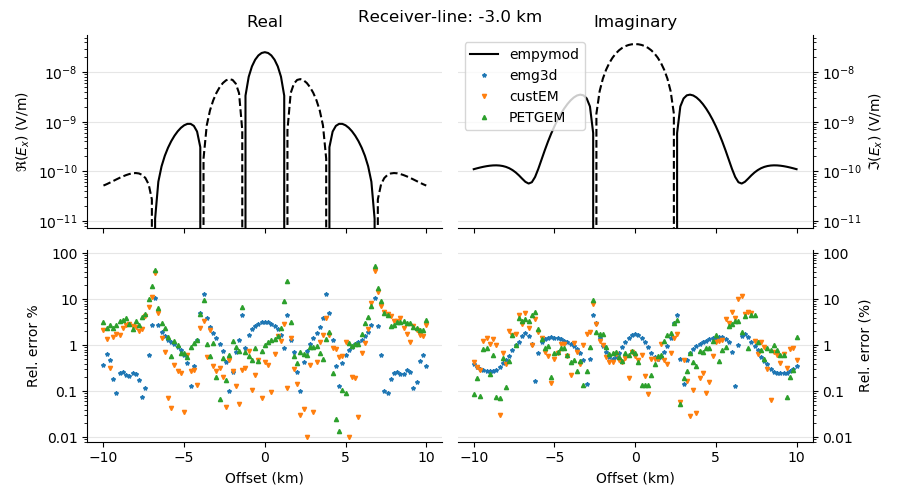

<IPython.core.display.Javascript object>


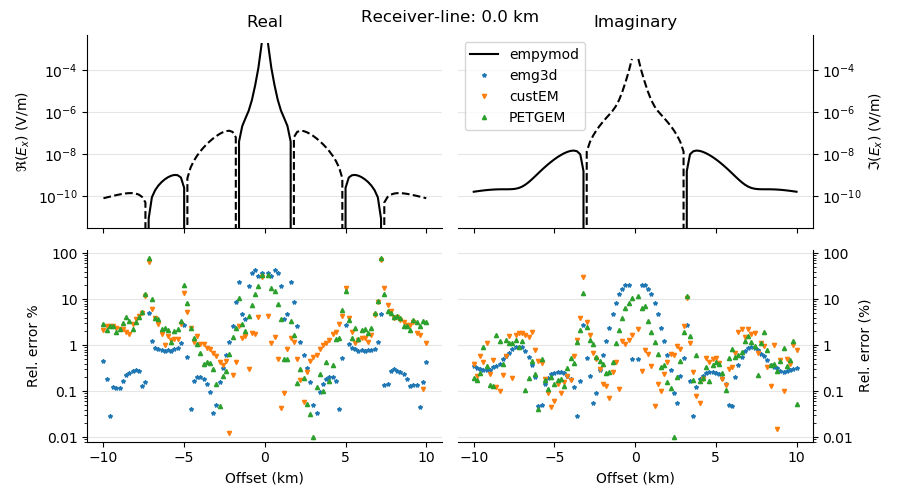

In [11]:
marker = ['*', 'v', '^', 'o']

for iy, y in enumerate(rec_y[:2]):

    plt.figure(figsize=(9, 5))

    # # Real
    ax1 = plt.subplot(221)
    plt.title('Real')

    plt.plot(rec_x/1e3, epm_1d[:, iy].real, 'k-', label='empymod')
    plt.plot(rec_x/1e3, -epm_1d[:, iy].real, 'k--')


    plt.ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    plt.grid(axis='y', c='0.9')


    # # Real Error
    ax2 = plt.subplot(223)

    for i, name in enumerate(error.keys()):
        plt.plot(rec_x/1e3, error[name][:, iy].real, f'C{i}{marker[i]}', ms=3, label=name)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.ylabel('Rel. error %')
    plt.ylim([8e-3, 120])
    plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    plt.grid(axis='y', c='0.9')
    plt.xlabel('Offset (km)')


    # # Imaginary
    ax3 = plt.subplot(222, sharey=ax1)
    plt.title('Imaginary')

    plt.plot(rec_x/1e3, epm_1d[:, iy].imag, 'k-', label='empymod')
    plt.plot(rec_x/1e3, -epm_1d[:, iy].imag, 'k--')
    
    # Legend
    for i, name in enumerate(error.keys()):
        plt.plot(0, -1, f'C{i}{marker[i]}', ms=3, label=name)
    plt.legend(loc=2)
    
    plt.yscale('log')
    plt.ylabel(r'$\Im(E_x)$ (V/m)')

    ax3.set_xticklabels([])
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')


    # # Imaginary Error
    ax4 = plt.subplot(224, sharey=ax2)

    for i, name in enumerate(error.keys()):
        plt.plot(rec_x/1e3, error[name][:, iy].imag, f'C{i}{marker[i]}', ms=3, label=name)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.xlabel('Offset (km)')
    plt.ylabel('Rel. error (%)')
    plt.ylim([8e-3, 120])
    plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    plt.tight_layout()

    #plt.savefig(f'../manuscript/figures/results-layered-{int(y/1e3)}.pdf', bbox_inches='tight')
    plt.suptitle(f'Receiver-line: {y/1e3} km')
    plt.show()

## Compare 3D model

In [12]:
# Collect data
data = {'emg3d': egd_tg, 'custEM': cst_tg, 'PETGEM': ptg_tg} #, 'SimPEG': spg_tg}

In [13]:
# Calculate normalized difference
ndiff = {}
for name, data1, data2 in zip(['emg3d-custEM', 'custEM-PETGEM'],
                              [egd_tg, cst_tg],
                              [cst_tg, ptg_tg],
                              ):
    rndiff = np.clip(50*abs((data1.real-data2.real)/(data1.real+data2.real)), 0.01, 100)
    indiff = np.clip(50*abs((data1.imag-data2.imag)/(data1.imag+data2.imag)), 0.01, 100)
    ndiff[name] = rndiff + 1j*indiff

<IPython.core.display.Javascript object>


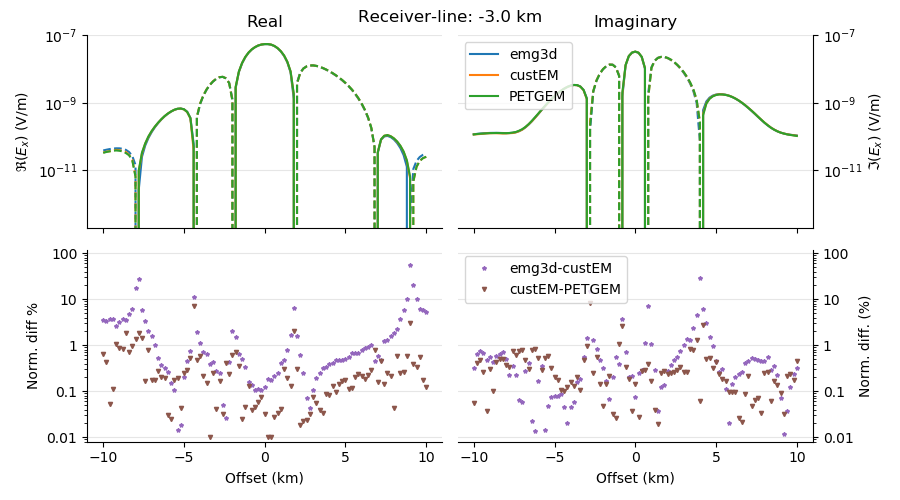

<IPython.core.display.Javascript object>


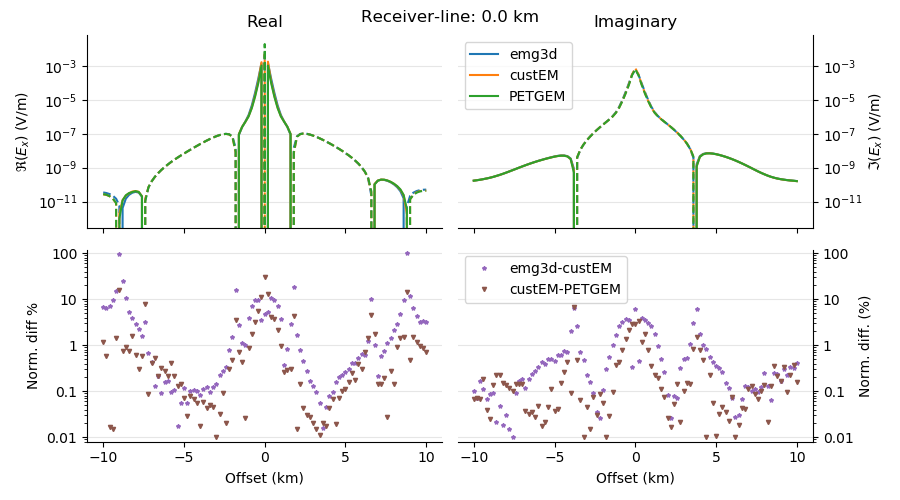

<IPython.core.display.Javascript object>


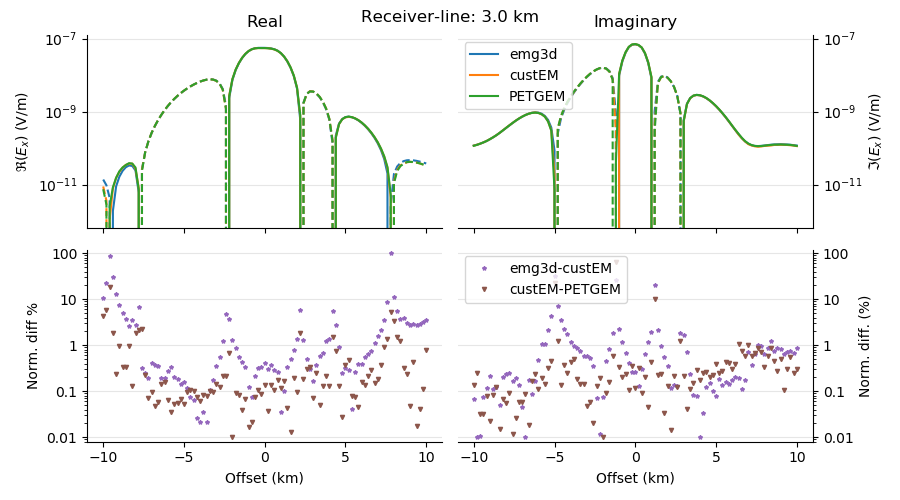

In [14]:
marker = ['*', 'v', '^', 'o']

for iy, y in enumerate(rec_y):

    plt.figure(figsize=(9, 5))

    # # Real
    ax1 = plt.subplot(221)
    plt.title('Real')

    for i, name in enumerate(data.keys()):
        plt.plot(rec_x/1e3, data[name][:, iy].real, f'C{i}-', ms=3, label=name)
        plt.plot(rec_x/1e3, -data[name][:, iy].real, f'C{i}--', ms=3)

    plt.ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    plt.grid(axis='y', c='0.9')


    # # Real normalized difference
    ax2 = plt.subplot(223)

    for i, name in enumerate(ndiff.keys()):
        plt.plot(rec_x/1e3, ndiff[name][:, iy].real, f'C{i+4}{marker[i]}', ms=3, label=name)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.ylabel('Norm. diff %')
    plt.ylim([8e-3, 120])
    plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    plt.grid(axis='y', c='0.9')
    plt.xlabel('Offset (km)')


    # # Imaginary
    ax3 = plt.subplot(222, sharey=ax1)
    plt.title('Imaginary')

    for i, name in enumerate(data.keys()):
        plt.plot(rec_x/1e3, data[name][:, iy].imag, f'C{i}-', ms=3, label=name)
        plt.plot(rec_x/1e3, -data[name][:, iy].imag, f'C{i}--', ms=3)
    
    plt.legend(loc=2)
    plt.yscale('log')
    plt.ylabel(r'$\Im(E_x)$ (V/m)')

    ax3.set_xticklabels([])
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')


    # # Imaginary normalized difference
    ax4 = plt.subplot(224, sharey=ax2)

    for i, name in enumerate(ndiff.keys()):
        plt.plot(rec_x/1e3, ndiff[name][:, iy].imag, f'C{i+4}{marker[i]}', ms=3, label=name)

    plt.legend(loc=2)
    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.xlabel('Offset (km)')
    plt.ylabel('Norm. diff. (%)')
    plt.ylim([8e-3, 120])
    plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    plt.tight_layout()

    plt.savefig(f'../manuscript/figures/results-block-{int(y/1e3)}.pdf', bbox_inches='tight')
    plt.suptitle(f'Receiver-line: {y/1e3} km')
    plt.show()